In [1]:
# Getting the dataset
!gdown --id 1jkWDUCaQF6-l8OZHXhv8e38-l9iuxjwc &> /dev/null
!unzip /content/celeb_data256x256.zip &> /dev/null

In [2]:
# Creating directories to store test-train data
!mkdir "/content/data/"
!mkdir "/content/data/train/"
!mkdir "/content/data/test/"
!mkdir "/content/data/train/dataset/"
!mkdir "/content/data/test/dataset/"

In [3]:
# Models and Test data will be stored in drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Should be modified when using
drive_path = '/content/drive/MyDrive/random_mask_unet/'

In [5]:
# Making test-train split
import os
import random
import shutil

src_dir = "/content/data256x256/"
dest_dir_train = "/content/data/train/dataset/"
dest_dir_test = "/content/data/test/dataset/"

cnt = 0

files = os.listdir(src_dir)
random.shuffle(files)

for count, filename in enumerate(files):
  # 80-20 Split
  src = src_dir + filename
  if 24000 > cnt:
    # First 80%
    des = dest_dir_train
  else:
    # Rest 20%
    des = dest_dir_test
  dest = shutil.move(src, des)
  cnt += 1

In [6]:
# Copying test on drive for furthur evaluvation
!cp -r "/content/data/test/dataset/" "/content/drive/MyDrive/random_mask_unet/test/"

In [7]:
# Imports
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2

In [8]:
# Creating Generator
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
        "/content/data/train/", target_size = (256, 256),color_mode = "rgb", batch_size=50,class_mode = "input")

Found 24000 images belonging to 1 classes.


In [9]:
# Metric
def dice_coefficient(y_true, y_pred):
    y_true_flattened = keras.backend.flatten(y_true)
    y_pred_flattened = keras.backend.flatten(y_pred)
    x = keras.backend.sum(y_true_flattened * y_pred_flattened)
    y=keras.backend.sum(y_true_flattened + y_pred_flattened)
    return 2*x/y

In [10]:
# Model

class Generator():
  # UNET model
  def train_model(self, input_size=(256,256,3)):
    inputs = keras.layers.Input(input_size)
    acti_function = "relu"
    padding = "same"
    filters = 32
    kernel_size = (3,3)
    pool_size = (2,2)
    up_kernel = (2,2)
    up_stride = (2,2)
    # encoder 
    conv1, pooling1 = self.Convulation_layer(filters,kernel_size, pool_size, acti_function, padding, inputs)
    conv2, pooling2 = self.Convulation_layer(filters*2, kernel_size, pool_size, acti_function, padding, pooling1)
    conv3, pooling3 = self.Convulation_layer(filters*4, kernel_size, pool_size, acti_function,padding, pooling2) 
    conv4, pooling4 = self.Convulation_layer(filters*8, kernel_size, pool_size, acti_function,padding, pooling3) 
    # decoder 
    conv5, up6 = self.Up_Convulation_layer(filters*16, filters*8, kernel_size, up_kernel, up_stride, acti_function, padding, pooling4, conv4)
    conv6, up7 = self.Up_Convulation_layer(filters*8, filters*4, kernel_size, up_kernel, up_stride, acti_function,padding, up6, conv3)
    conv7, up8 = self.Up_Convulation_layer(filters*4, filters*2, kernel_size, up_kernel, up_stride, acti_function, padding, up7, conv2)
    conv8, up9 = self.Up_Convulation_layer(filters*2,filters, kernel_size, up_kernel, up_stride, acti_function,padding, up8, conv1)
    conv9 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(up9)
    conv9 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(conv9)
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)
    return keras.models.Model(inputs=[inputs], outputs=[outputs]) 
    
  def Convulation_layer(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    pooling = keras.layers.MaxPooling2D(pool_size)(conv)
    return conv, pooling

  def Up_Convulation_layer(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)
    return conv, up

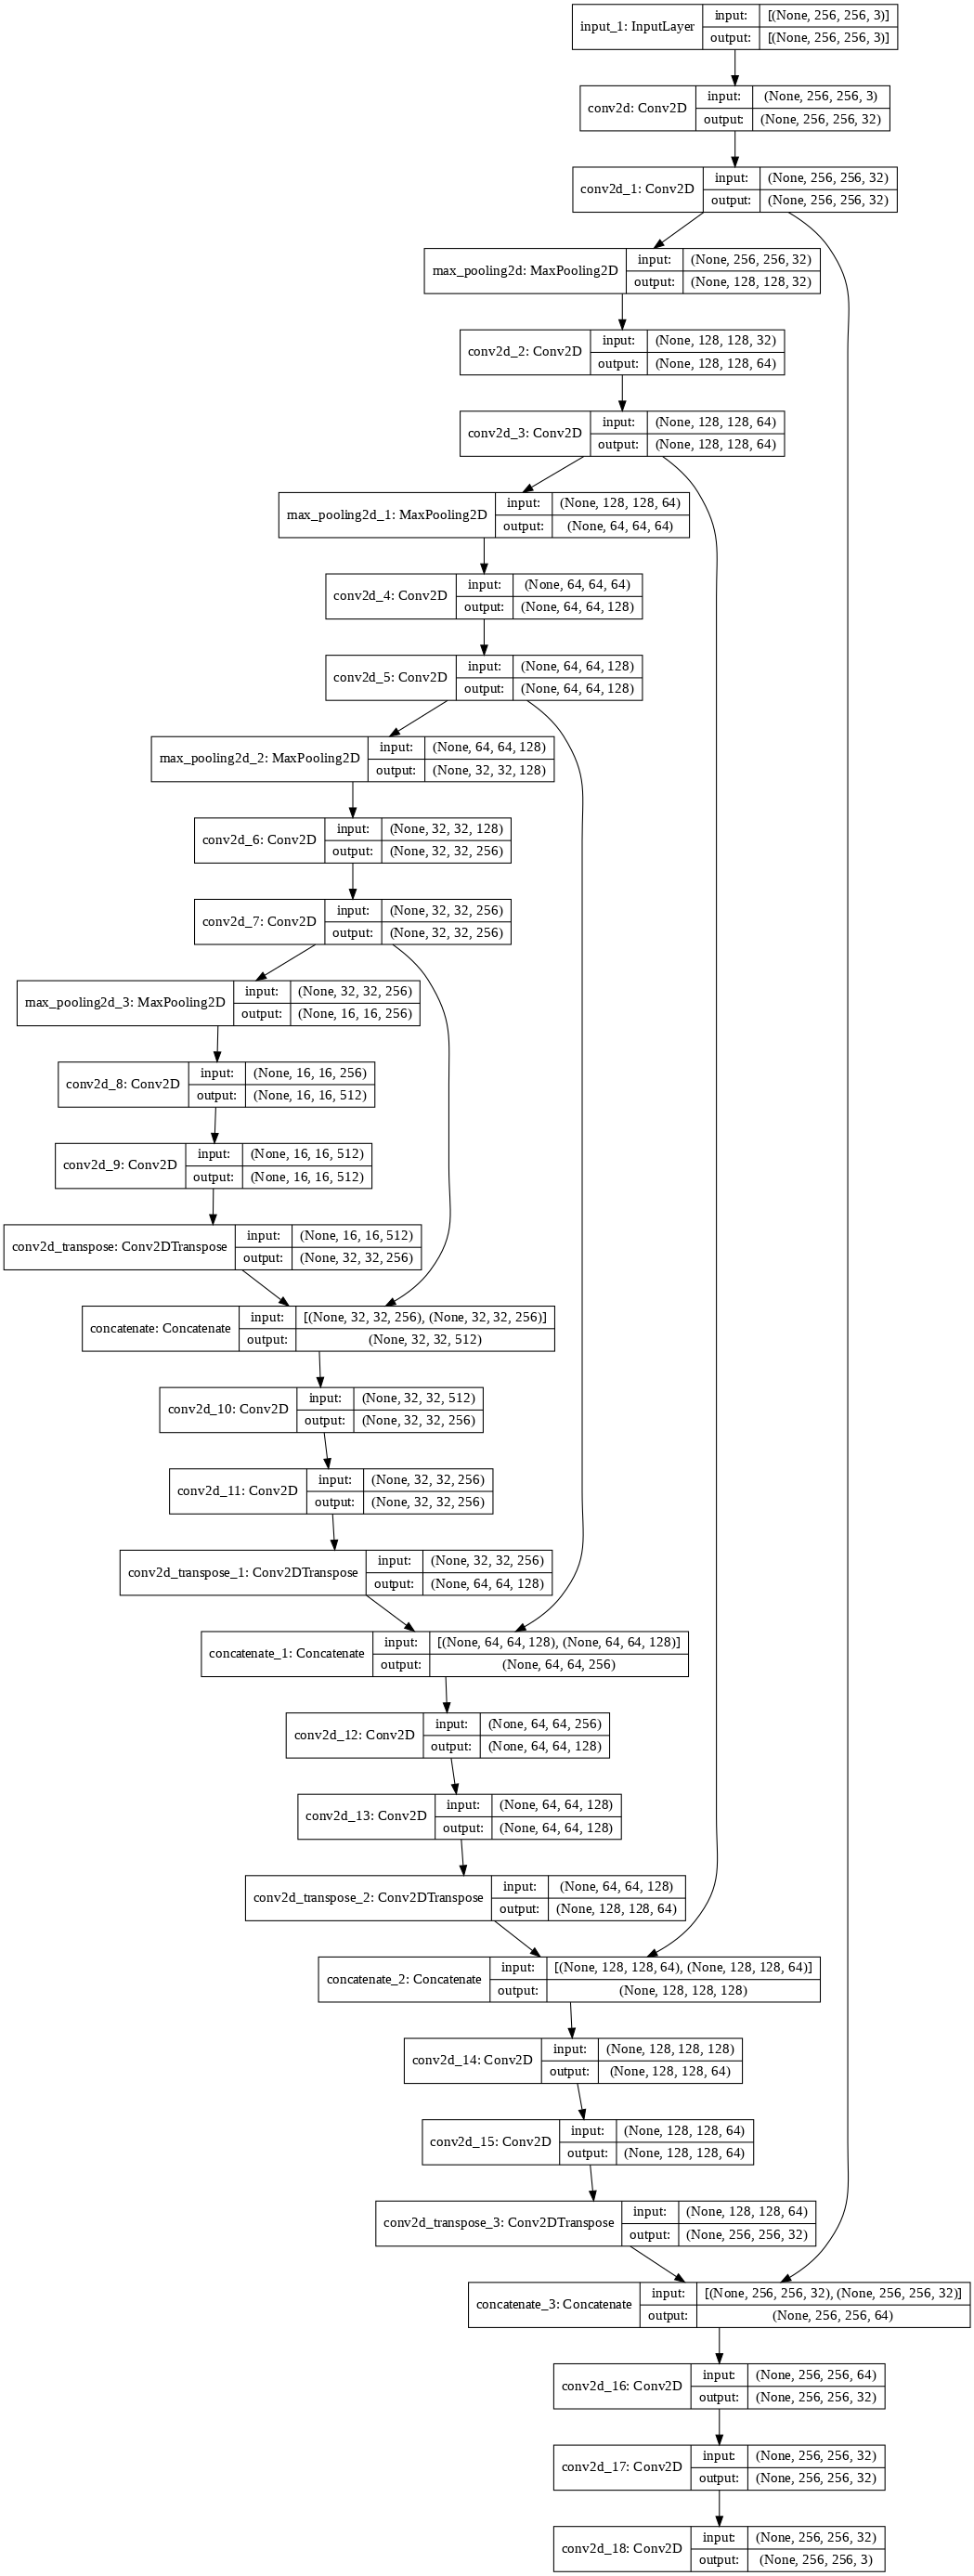

In [11]:
# Compiling and plotting model
keras.backend.clear_session()
model = Generator().train_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coefficient])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model.png')

In [12]:
def getMask():
  # Generates a random mask
  mask = np.full((256,256,3), 255, np.uint8)
  mask_len = 64
  x_mask = np.random.randint(50,256-mask_len-50)
  y_mask = np.random.randint(50,256-mask_len-50)
  for i in range(3):
      for j in range(256):
          for k in range(256):
              if j>x_mask and x_mask+mask_len>j and k>y_mask and y_mask+mask_len>k:
                  mask[j][k][i] = 1
  return mask

# Creating masks for images
def createmask(img):
  # Applies a mask on img
  img = img.astype(np.uint8)
  masked_image = np.copy(img)
  for l in range(len(img)):
    mask = getMask()
    masked_image[l] = cv2.bitwise_and(img[l], mask)
  return masked_image/255

In [13]:
import sys
from tqdm import tqdm

epochs = 10
cnt = 0
num_images = 24000
batch_size = 50
batch_images = num_images//batch_size
fp = open(drive_path + "logs.txt","a")

# Training loop
for epoch in tqdm(range(epochs)):
  for x,y in train_generator:
    x_mask = createmask(x)
    orignal = sys.stdout
    # logs are wriiten in drive. This is accompilished by altering file descripters.
    sys.stdout = fp
    model.fit(x_mask,y/255,batch_size = batch_size,verbose = 2)
    # Reseting stdout file descripter 
    sys.stdout = orignal
    cnt += 1
    if (cnt == batch_images):
      break
  # Saving model per epoch
  model.save_weights(drive_path+str(epoch)+".h5")
  cnt = 0
fp.close()

100%|██████████| 10/10 [2:47:00<00:00, 1002.08s/it]


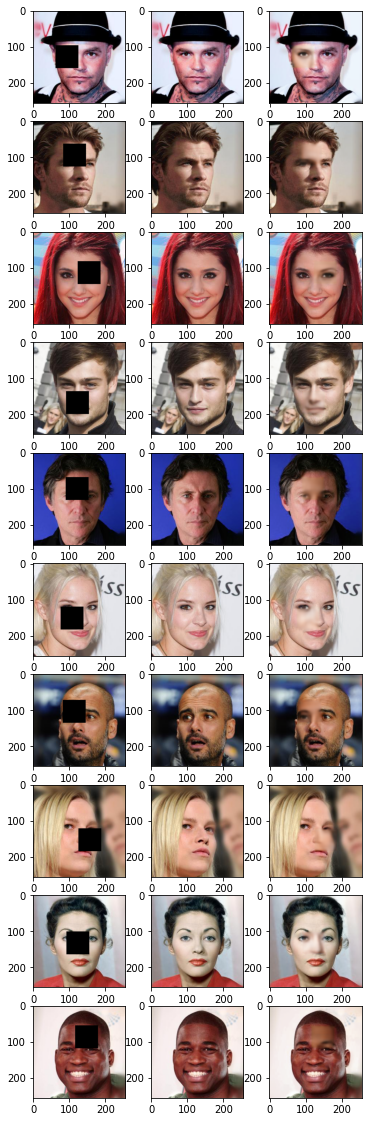

In [15]:
# if epoch == 0:
import matplotlib.pyplot as plt
rows = 10
fig, ax = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))
for x,y in train_generator:
    x_mask = createmask(x).astype(np.float32)
    yhat = model.predict(x_mask)
    for i in range(rows):
        ax[i][0].imshow(x_mask[i])
        ax[i][1].imshow(y[i]/255)
        ax[i][2].imshow(yhat[i])
    break
plt.show()